# Introduction

**TRIGGER WARNING**:

This notebook aims at creating a model to identify violent language expressed on the platform Tweeter (now X) as well as recogniting emotion through text.

This repository can be considered as an extention of ***tweet_emotion_recognition***.

What moved me to decide this was the right project for the graduation at IronHack is that I believe violence has no place, anywhere, and it should be monitored in the social media community as violent language and cyber mobbing can scar one's self esteem and lead to extreme actions by the victim of such violence.

With this notebook I want to establish a model which identifies emotions and in case of violent language and reports it automatically to the operating team of the platform. The request is to have the user profile reviewed and see if there's the extreme to ban the profile permanently.

Please be aware that the content of the datasets used contains language and comments which might be disturbing to you due to their nature.

If you are sensitive to these topics but still interested to learn about my work, please interrupt reviewing this notebook but feel free to connect with me separately to discuss about the topic together.

In [1]:
#required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import nlp
import tensorflow as tf
from transformers import pipeline, AutoTokenizer

#setting to avoid truncation of the text rows

pd.set_option('display.max_colwidth', None)

In [2]:
#extracting data for the base emotions df

data = pd.read_csv('c:/Data_Science/IH_Notebooks/IH_NLP_Final_Project/text.csv')
emotion_df = data.copy()

emotion_df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing,0
2,2,i gave up my internship with the dmrg and am feeling distraught,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughly weary of my job after having taken the university entrance exam i suffered from anxiety for weeks as i did not want to carry on with my work studies were the only alternative,4


In [3]:
#extracting the data for the hate df and violence df



data2 = pd.read_csv('c:/Data_Science/IH_Notebooks/IH_NLP_Final_Project/labeled_data.csv')

hate_df = data2.copy()

data3 = pd.read_csv('c:/Data_Science/IH_Notebooks/IH_NLP_Final_Project/Train.csv')
violence_df = data3.copy()

print(hate_df.head(3))
print(violence_df.head(3))

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   

                                                                                                                                          tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...  
1                                                         !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!  
2                      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit  
      Tweet_ID  \
0  ID_0022DWKP   
1  ID_00395QYM   
2  ID_003EOSSF   

                                                  

# Data Cleaning

In [4]:
#dropping unnecessary columns

emotion_df = emotion_df.drop(columns='Unnamed: 0')

violence_df = violence_df.drop(columns='Tweet_ID')

hate_df = hate_df[['tweet', 'class']]

print("First 3 rows of emotion_df after column drop: \n", emotion_df.head(3))

print("First 3 rows of hate_df after column drop: \n", hate_df.head(3))

print("First 3 rows of violence_df after column drop: \n", violence_df.head(3))

First 3 rows of emotion_df after column drop: 
                                                                                                                                                                                                                                          text  \
0                                                                                                                                                                                               i just feel really helpless and heavy hearted   
1  ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing   
2                                                                                                                                                                             i gave up my internship with the dmrg and am feeling di

In [5]:
emotion_df.columns, hate_df.columns, violence_df.columns

(Index(['text', 'label'], dtype='object'),
 Index(['tweet', 'class'], dtype='object'),
 Index(['tweet', 'type'], dtype='object'))

In [6]:
#renaming the columns for hate and violence df

hate_df = hate_df.rename(columns={'tweet': 'text', 'class': 'label'})
violence_df = violence_df.rename(columns={'tweet': 'text', 'type': 'label'})

In [7]:
emotion_df.isnull().sum(), hate_df.isnull().sum(), violence_df.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

## Distribution Bar Plots

In [8]:
emotion_plot_df = emotion_df.copy()

emotion_map = {
    0 : "Sadness",
    1: "Joy",
    2: "Love",
    3: "Anger",
    4: "Fear",
    5: "Surprise"
}

emotion_plot_df['emotion'] = emotion_plot_df['label'].map(emotion_map)

emotion_distribuion = emotion_plot_df.groupby('emotion')['label'].count()

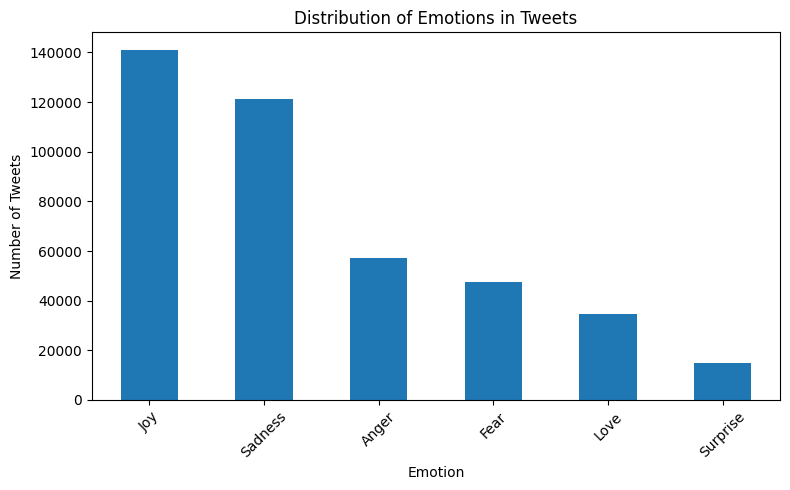

In [9]:
#Plot to show emotion distribution

plt.figure(figsize=(8, 5))
emotion_distribuion.sort_values(ascending=False).plot(kind='bar')

plt.title('Distribution of Emotions in Tweets')
plt.xlabel('Emotion')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
hate_plot_df = hate_df.copy()

hate_map = {
    0: "Hate Speech",
    1: "Offensive",
    2: "Neither"
}

hate_plot_df['grade'] = hate_plot_df['label'].map(hate_map)

hate_distribution = hate_plot_df.groupby('grade')['label'].count()

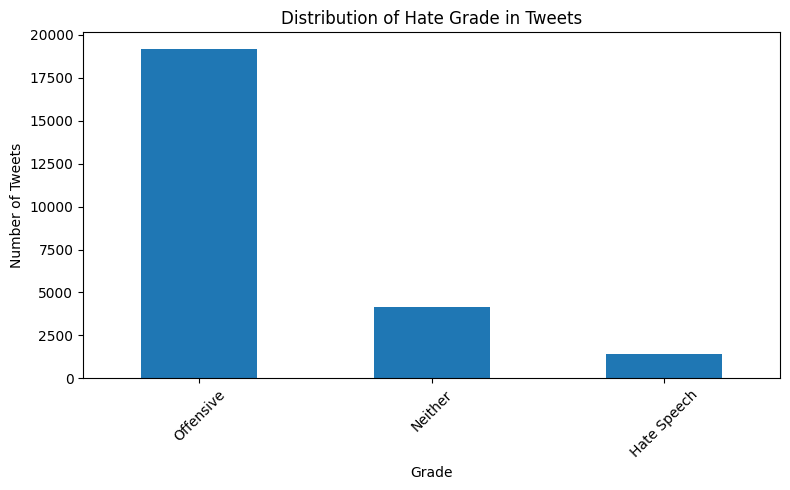

In [11]:
#Plot to show hate grade distribution

plt.figure(figsize=(8, 5))
hate_distribution.sort_values(ascending=False).plot(kind='bar')

plt.title('Distribution of Hate Grade in Tweets')
plt.xlabel('Grade')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

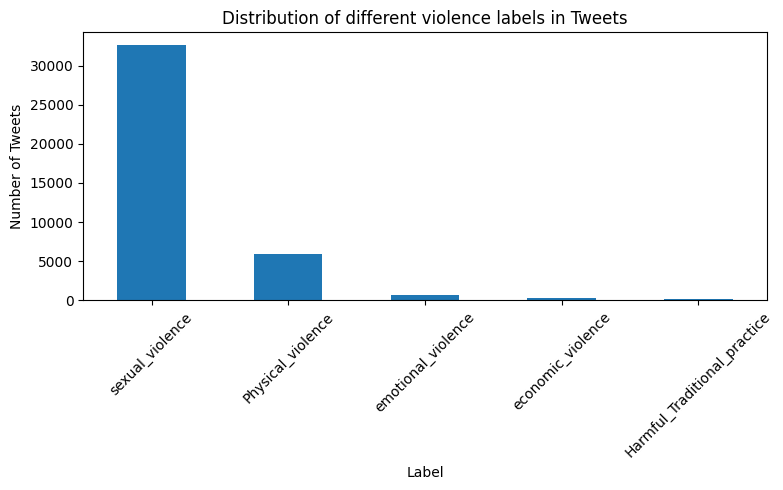

In [12]:
#Plot to show hate grade distribution

plt.figure(figsize=(8, 5))
violence_df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

plt.title('Distribution of different violence labels in Tweets')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
import re

In [14]:
#cleaning the text

from my_functions import clean_text

emotion_df['clean_text'] = emotion_df['text'].apply(clean_text)

hate_df['clean_text'] = hate_df['text'].apply(clean_text)

violence_df['clean_text'] = violence_df['text'].apply(clean_text)


In [ ]:
emotion_df = emotion_df.drop(columns='text')

hate_df = hate_df.drop(columns='text')

violence_df = violence_df.drop(columns='text')

#moving the label column back on the right of the df

emotion_label_placeholder = emotion_df.pop('label')

emotion_df['label'] = emotion_label_placeholder

hate_label_placeholder = hate_df.pop('label')

hate_df['label'] = hate_label_placeholder

violence_label_placeholder = violence_df.pop('label')

violence_df['label'] = violence_label_placeholder

#Checking the results

print("First 3 rows of emotion_df: \n", emotion_df.head(3))

print("First 3 rows of hate_df: \n", hate_df.head(3))

print("First 3 rows of violence_df: \n", violence_df.head(3))



First 3 rows of emotion_df after column drop: 
                                                                                                                                                                                                                                    clean_text  \
0                                                                                                                                                                                               i just feel really helpless and heavy hearted   
1  ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing   
2                                                                                                                                                                             i gave up my internship with the dmrg and am feeling di

## Resample: emotion_df

In [21]:
emotion_df = emotion_df.rename(columns={'clean_text': 'text'})
emotion_df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing,0
2,i gave up my internship with the dmrg and am feeling distraught,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughly weary of my job after having taken the university entrance exam i suffered from anxiety for weeks as i did not want to carry on with my work studies were the only alternative,4
...,...,...
416804,i feel like telling these horny devils to find a site more suited to that sort of interest the playboy if there is one forum perhaps,2
416805,i began to realize that when i was feeling agitated or restless that i would have a thought to go do the dishes,3
416806,i feel very curious be why previous early dawn in the time here don t you seek his trouble,5
416807,i feel that becuase of the tyranical nature of the government in el salvador and the savage social conditions of the general people that the set of thought to run the shoe shop in miguel marmols testimoney was able to work,3


In [20]:
from sklearn.utils import resample

#resampling emotion_df to have 6000 rows

sadness = emotion_df.loc[emotion_df['label'] == 0]
joy = emotion_df.loc[emotion_df['label'] == 1]
love = emotion_df.loc[emotion_df['label'] == 2]
anger = emotion_df.loc[emotion_df['label'] == 3]
fear = emotion_df.loc[emotion_df['label'] == 4]
surprise = emotion_df.loc[emotion_df['label'] == 5]

undersampled_sadness = resample(sadness, replace=True, n_samples=1000, random_state=42)
undersampled_joy = resample(joy, replace=True, n_samples=1000, random_state=42)
undersampled_love = resample(love, replace=True, n_samples=1000, random_state=42)
undersampled_anger = resample(anger, replace=True, n_samples=1000, random_state=42)
undersampled_fear = resample(fear, replace=True, n_samples=1000, random_state=42)
undersampled_surprise = resample(surprise, replace=True, n_samples=1000, random_state=42)

dfs = [undersampled_sadness, undersampled_joy, undersampled_love, undersampled_anger, undersampled_fear, undersampled_surprise]

undersampled_emotion_df = pd.concat(dfs, ignore_index=True)

undersampled_emotion_df


,clean_text,label
0,im feeling terrible,0
1,i am lbs overweight and the sudden burst of training has left me feeling dull and stale,0
2,i usually feel resigned that if i know it i know it if not it is too late now,0
3,i was a part of that group but i left due to feeling disheartened with my internet speed and lack of money to buy a second hand one and i created my own group for artipoppe virgins those who have never managed to bag one for themselves,0
4,i am so far from normal that it s not funny i just feel stupid and tiny and cheated,0
...,...,...
5995,i think is slowly killing me and feeling like crud i am surprised i made it to friday,5
5996,i started feeling flu ish i was pretty surprised,5
5997,i have used these opportunities to feel contempt disgust and shame about the others instead of truly being curious about what motivates their behavior and what are they are attempting to share about themselves,5
5998,im sick of being exhausted all the time of rushing around school of feeling dazed and repressed of not having time to see my friends because i have too much to do of worrying about grades of forcing myself to tolerate small talk,5
